# Исследование сервиса GoFast

**Цель исследования:**
проверить гипотезы о пользователях с подпиской и без

**Описание данных:**
Чтобы совершать поездки по городу, пользователи сервиса GoFast пользуются мобильным приложением. Сервисом можно пользоваться:
* без подписки 

абонентская плата отсутствует;
стоимость одной минуты поездки — 8 рублей;
стоимость старта (начала поездки) — 50 рублей;
* с подпиской Ultra 

абонентская плата — 199 рублей в месяц;
стоимость одной минуты поездки — 6 рублей;
стоимость старта — бесплатно.

 **Пользователи — users_go.csv**
* user_id	уникальный идентификатор пользователя
* name	имя пользователя
* age	возраст
* city	город
* subscription_type	тип подписки (free, ultra)

 **Поездки — rides_go.csv**
* user_id	уникальный идентификатор пользователя
* distance	расстояние, которое пользователь проехал в текущей сессии (в метрах)
* duration	продолжительность сессии (в минутах) — время с того момента, как пользователь нажал кнопку «Начать поездку» до момента, как он нажал кнопку «Завершить поездку»
* date	дата совершения поездки

 **Подписки — subscriptions_go.csv**
* subscription_type	тип подписки
* minute_price	стоимость одной минуты поездки по данной подписке
* start_ride_price	стоимость начала поездки
* subscription_fee	стоимость ежемесячного платежа

**План работы**:

**1. Импортировать библиотеки. Загрузить датафреймы. Изучить общую информацию.**

**2. Предобработка данных:**
* проверка на пропуски и дубликаты
* создание нового столбца с номером месяца на основе столбца date.

**3. Исследовательский анализ данных**

Описать и визуализировать общую информацию о пользователях и поездках:
* частота встречаемости городов;
* соотношение пользователей с подпиской и без подписки;
* возраст пользователей;
* расстояние, которое пользователь преодолел за одну поездку;
* продолжительность поездок.

**4. Объединение данных**
* Объединить данные о пользователях, поездках и подписках в один датафрейм
* Создать ещё два датафрейма:c данными о пользователях без подписки;с данными о пользователях с подпиской.
* Визуализировать информацию о расстоянии и времени поездок для пользователей обеих категорий.

**5. Подсчёт выручки**
* Создать датафрейм с агрегированными данными о поездках: найти суммарное расстояние, количество поездок и суммарное время для каждого пользователя за каждый месяц.
* В этот же датафрейм добавим столбец с помесячной выручкой, которую принёс каждый пользователь.

**6. Проверка гипотез**
* Понять, тратят ли пользователи с подпиской больше времени на поездки?
* Проверить, если среднее расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает 3130 метров?
* Проверить, будет ли помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats as st

### шаг. Загрузка данных

In [2]:
users = pd.read_csv('/datasets/users_go.csv')
users.info()
users.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1565 entries, 0 to 1564
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   user_id            1565 non-null   int64 
 1   name               1565 non-null   object
 2   age                1565 non-null   int64 
 3   city               1565 non-null   object
 4   subscription_type  1565 non-null   object
dtypes: int64(2), object(3)
memory usage: 61.3+ KB


,user_id,name,age,city,subscription_type
0,1,Кира,22,Тюмень,ultra
1,2,Станислав,31,Омск,ultra
2,3,Алексей,20,Москва,ultra
3,4,Константин,26,Ростов-на-Дону,ultra
4,5,Адель,28,Омск,ultra


In [3]:
rides = pd.read_csv('/datasets/rides_go.csv', parse_dates=['date'])
rides.info()
rides.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   user_id   18068 non-null  int64         
 1   distance  18068 non-null  float64       
 2   duration  18068 non-null  float64       
 3   date      18068 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(2), int64(1)
memory usage: 564.8 KB


,user_id,distance,duration,date
0,1,4409.919140,25.599769,2021-01-01
1,1,2617.592153,15.816871,2021-01-18
2,1,754.159807,6.232113,2021-04-20
3,1,2694.783254,18.511000,2021-08-11
4,1,4028.687306,26.265803,2021-08-28


In [4]:
subscriptions = pd.read_csv('/datasets/subscriptions_go.csv')
subscriptions.info()
subscriptions.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   subscription_type  2 non-null      object
 1   minute_price       2 non-null      int64 
 2   start_ride_price   2 non-null      int64 
 3   subscription_fee   2 non-null      int64 
dtypes: int64(3), object(1)
memory usage: 192.0+ bytes


,subscription_type,minute_price,start_ride_price,subscription_fee
0,free,8,50,0
1,ultra,6,0,199


Меньше всего информации в датафрейме subscription, здесь у нас в две строки описаны условия оплаты. Датафрейм users состоит из 1565 строк с информацией о пользователях: номер id, имя, возраст, город и тип подписки. Датафрейм rides самый большой, 18068 строк с данными по каждой поездке: дата, номер пользователя, расстояние в метрах и продолжительность в минутах.

### шаг. Предобработка данных

Проверим датафреймы users и rides на явные дубликаты:

In [5]:
users.duplicated()
users = users.drop_duplicates().reset_index(drop=True)
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1534 entries, 0 to 1533
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   user_id            1534 non-null   int64 
 1   name               1534 non-null   object
 2   age                1534 non-null   int64 
 3   city               1534 non-null   object
 4   subscription_type  1534 non-null   object
dtypes: int64(2), object(3)
memory usage: 60.0+ KB


Изначально в данном датафрейме было 1565, стало 1534. Был удалён 31 дубликат.

In [6]:
rides.duplicated()
rides = rides.drop_duplicates().reset_index(drop=True)
rides.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   user_id   18068 non-null  int64         
 1   distance  18068 non-null  float64       
 2   duration  18068 non-null  float64       
 3   date      18068 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(2), int64(1)
memory usage: 564.8 KB


До обработки данный датафрейм также содержал 18068 строк. Дубликатов не было.

Загрузила датафреймы, при загрузке сразу привела столбец date к корректному типу данных. С  остальными столбцами проблем нет. Добавим новый столбец с номерами месяцев. На всякий случай проверим за какой год у нас данные.

In [7]:
rides['month'] =  pd.DatetimeIndex(rides['date']).month
rides.head()

,user_id,distance,duration,date,month
0,1,4409.919140,25.599769,2021-01-01,1
1,1,2617.592153,15.816871,2021-01-18,1
2,1,754.159807,6.232113,2021-04-20,4
3,1,2694.783254,18.511000,2021-08-11,8
4,1,4028.687306,26.265803,2021-08-28,8


In [8]:
pd.DatetimeIndex(rides['date']).year.value_counts()

2021    18068
Name: date, dtype: int64

In [9]:
users.isna().sum()

user_id              0
name                 0
age                  0
city                 0
subscription_type    0
dtype: int64

In [10]:
rides.isna().sum()

user_id     0
distance    0
duration    0
date        0
month       0
dtype: int64

In [11]:
users['city'].sort_values().unique()

array(['Екатеринбург', 'Краснодар', 'Москва', 'Омск', 'Пятигорск',
       'Ростов-на-Дону', 'Сочи', 'Тюмень'], dtype=object)

In [12]:
users['subscription_type'].sort_values().unique()

array(['free', 'ultra'], dtype=object)

Проверила, пропусков нет. От явных дубликатов я избавлялась на стадии получения общей информации. Подумала, где могут быть неявные. Решила, что это столбцы с типом подписки и названием города. Проверила, их там нет.

### шаг. Исследовательский анализ данных

Теперь опишем и визуализируем общую информацию о пользователях и поездках:

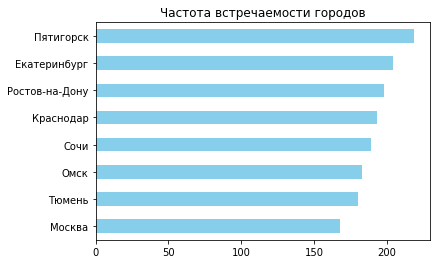

In [13]:
values = users['city'].value_counts().sort_values(ascending=True)

fig, ax = plt.subplots()
values.plot(kind='barh', color='skyblue')

ax.set_title('Частота встречаемости городов')
plt.show()

Всего  8 городов. Самый популярный -- Пятигорск, но разброс небольшой.

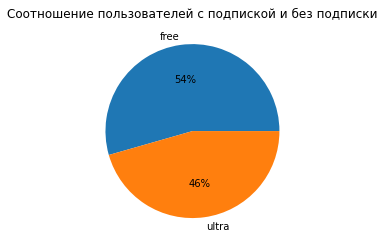

In [14]:
subscription_counts = users['subscription_type'].value_counts()

subscription_counts.plot(
    kind= 'pie',
    title= 'Соотношение пользователей с подпиской и без подписки',
    autopct = "%.0f%%",
    ylabel= ""
)
plt.show()

Большинство пользователей без подписки. Но опять-таки разница небольшая.

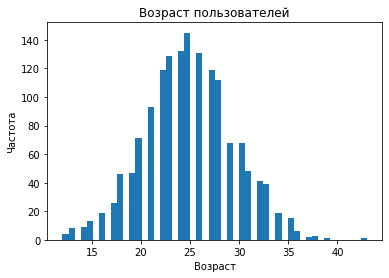

count    1534.000000
mean       24.903520
std         4.572367
min        12.000000
25%        22.000000
50%        25.000000
75%        28.000000
max        43.000000
Name: age, dtype: float64

In [15]:
plt.hist(users['age'], bins = 50)
plt.title('Возраст пользователей')
plt.xlabel('Возраст')
plt.ylabel('Частота')
plt.show()
users['age'].describe()

Средний возраст 25 лет, минимальный - 12. Очень мало пользователей старше 40 лет.

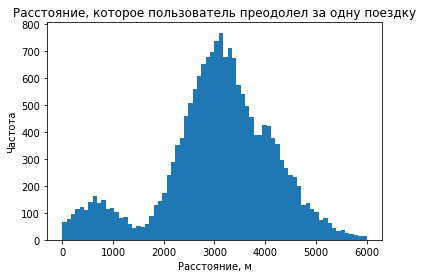

count    18068.000000
mean      3070.659976
std       1116.831209
min          0.855683
25%       2543.226360
50%       3133.609994
75%       3776.222735
max       7211.007745
Name: distance, dtype: float64

In [16]:
plt.hist(rides['distance'], bins = 70, range = (0,6000))
plt.title('Расстояние, которое пользователь преодолел за одну поездку')
plt.xlabel('Расстояние, м')
plt.ylabel('Частота')
plt.show()
rides['distance'].describe()

В среднем пользователи проезжают от 2500 до 3500 м за одну поездку. Достаточно много значений около 0, видимо что-то пошло не так и пользоватеель передумал ехать. Есть два пиковых значения. Тут скорее всего играет роль цель поездки. Короткими могут быть поездки до ближайшей остановки или станции метро, а длинными прогулочные поездки или поездки сразу до места работы(учебы)

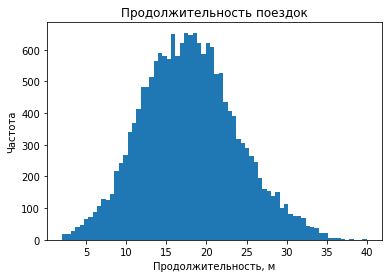

count    18068.000000
mean        17.805011
std          6.091051
min          0.500000
25%         13.597563
50%         17.678395
75%         21.724800
max         40.823963
Name: duration, dtype: float64

In [17]:
plt.hist(rides['duration'], bins = 70, range=(2,40))
plt.title('Продолжительность поездок')
plt.xlabel('Продолжительность, м')
plt.ylabel('Частота')
plt.show()
rides['duration'].describe()

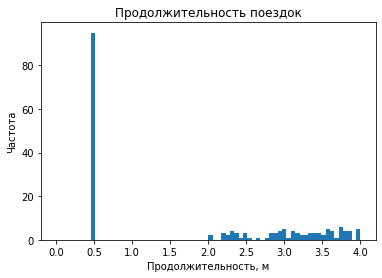

count    18068.000000
mean        17.805011
std          6.091051
min          0.500000
25%         13.597563
50%         17.678395
75%         21.724800
max         40.823963
Name: duration, dtype: float64

In [18]:
plt.hist(rides['duration'], bins = 70, range=(0,4))
plt.title('Продолжительность поездок')
plt.xlabel('Продолжительность, м')
plt.ylabel('Частота')
plt.show()
rides['duration'].describe()

По продолжительности большинство поездок занимают от 14 до 22 минут.

**Промежуточный вывод.** Большинство поездок от 14 до 22 минут, где пользователи проезжают от 2500 до 3500 м. Самый популярный город -- Пятигорск и большинство пользователей пользуются сервисом без подписки. Средний возраст 25 лет, минимальный - 12. Очень мало пользователей старше 40 лет.

### шаг. Объединение данных

Объединим данные о пользователях, поездках и подписках в один датафрейм.

In [19]:
data = users.merge(rides, on='user_id')
data

,user_id,name,age,city,subscription_type,distance,duration,date,month
0,1,Кира,22,Тюмень,ultra,4409.919140,25.599769,2021-01-01,1
1,1,Кира,22,Тюмень,ultra,2617.592153,15.816871,2021-01-18,1
2,1,Кира,22,Тюмень,ultra,754.159807,6.232113,2021-04-20,4
3,1,Кира,22,Тюмень,ultra,2694.783254,18.511000,2021-08-11,8
4,1,Кира,22,Тюмень,ultra,4028.687306,26.265803,2021-08-28,8
...,...,...,...,...,...,...,...,...,...
18063,1534,Альберт,25,Краснодар,free,3781.098080,19.822962,2021-11-04,11
18064,1534,Альберт,25,Краснодар,free,2840.423057,21.409799,2021-11-16,11
18065,1534,Альберт,25,Краснодар,free,3826.185507,18.435051,2021-11-18,11
18066,1534,Альберт,25,Краснодар,free,2902.308661,16.674362,2021-11-27,11


In [20]:
data = data.merge(subscriptions, on='subscription_type')
data

,user_id,name,age,city,subscription_type,distance,duration,date,month,minute_price,start_ride_price,subscription_fee
0,1,Кира,22,Тюмень,ultra,4409.919140,25.599769,2021-01-01,1,6,0,199
1,1,Кира,22,Тюмень,ultra,2617.592153,15.816871,2021-01-18,1,6,0,199
2,1,Кира,22,Тюмень,ultra,754.159807,6.232113,2021-04-20,4,6,0,199
3,1,Кира,22,Тюмень,ultra,2694.783254,18.511000,2021-08-11,8,6,0,199
4,1,Кира,22,Тюмень,ultra,4028.687306,26.265803,2021-08-28,8,6,0,199
...,...,...,...,...,...,...,...,...,...,...,...,...
18063,1534,Альберт,25,Краснодар,free,3781.098080,19.822962,2021-11-04,11,8,50,0
18064,1534,Альберт,25,Краснодар,free,2840.423057,21.409799,2021-11-16,11,8,50,0
18065,1534,Альберт,25,Краснодар,free,3826.185507,18.435051,2021-11-18,11,8,50,0
18066,1534,Альберт,25,Краснодар,free,2902.308661,16.674362,2021-11-27,11,8,50,0


In [21]:
data['duration'] = np.ceil(data['duration']) 

Создадим ещё два датафрейма:

c данными о пользователях без подписки;
с данными о пользователях с подпиской.

А затем визуализируем информацию о расстоянии и времени поездок для пользователей обеих категорий.

In [22]:
df_subscribed = data.query('subscription_type == "ultra"')
df_subscribed

,user_id,name,age,city,subscription_type,distance,duration,date,month,minute_price,start_ride_price,subscription_fee
0,1,Кира,22,Тюмень,ultra,4409.919140,26.0,2021-01-01,1,6,0,199
1,1,Кира,22,Тюмень,ultra,2617.592153,16.0,2021-01-18,1,6,0,199
2,1,Кира,22,Тюмень,ultra,754.159807,7.0,2021-04-20,4,6,0,199
3,1,Кира,22,Тюмень,ultra,2694.783254,19.0,2021-08-11,8,6,0,199
4,1,Кира,22,Тюмень,ultra,4028.687306,27.0,2021-08-28,8,6,0,199
...,...,...,...,...,...,...,...,...,...,...,...,...
6495,699,Оксана,22,Москва,ultra,3973.046497,25.0,2021-08-29,8,6,0,199
6496,699,Оксана,22,Москва,ultra,3288.702563,16.0,2021-09-12,9,6,0,199
6497,699,Оксана,22,Москва,ultra,3076.159348,15.0,2021-09-26,9,6,0,199
6498,699,Оксана,22,Москва,ultra,4707.845501,16.0,2021-10-17,10,6,0,199


In [23]:
df_no_subscribed = data.query('subscription_type == "free"')
df_no_subscribed

,user_id,name,age,city,subscription_type,distance,duration,date,month,minute_price,start_ride_price,subscription_fee
6500,700,Айдар,22,Омск,free,2515.690719,15.0,2021-01-02,1,8,50,0
6501,700,Айдар,22,Омск,free,846.932642,17.0,2021-02-01,2,8,50,0
6502,700,Айдар,22,Омск,free,4004.434142,21.0,2021-02-04,2,8,50,0
6503,700,Айдар,22,Омск,free,1205.911290,10.0,2021-02-10,2,8,50,0
6504,700,Айдар,22,Омск,free,3047.379435,18.0,2021-02-14,2,8,50,0
...,...,...,...,...,...,...,...,...,...,...,...,...
18063,1534,Альберт,25,Краснодар,free,3781.098080,20.0,2021-11-04,11,8,50,0
18064,1534,Альберт,25,Краснодар,free,2840.423057,22.0,2021-11-16,11,8,50,0
18065,1534,Альберт,25,Краснодар,free,3826.185507,19.0,2021-11-18,11,8,50,0
18066,1534,Альберт,25,Краснодар,free,2902.308661,17.0,2021-11-27,11,8,50,0


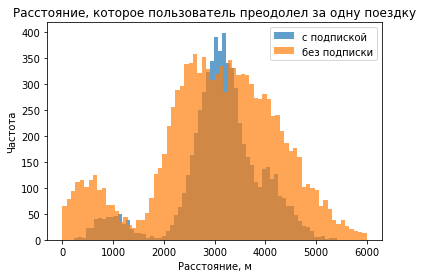

count    11568.000000
mean      3045.495282
std       1246.173806
min          0.855683
25%       2366.562689
50%       3114.648465
75%       3905.697894
max       7211.007745
Name: distance, dtype: float64

In [24]:
plt.hist(df_subscribed['distance'], bins = 70, range = (0,5500), alpha=0.7, label='с подпиской')
plt.hist(df_no_subscribed['distance'], bins = 70, range = (0,6000), alpha=0.7, label='без подписки')
plt.title('Расстояние, которое пользователь преодолел за одну поездку')
plt.xlabel('Расстояние, м')
plt.ylabel('Частота')
plt.legend()
plt.show()
df_subscribed['distance'].describe()
df_no_subscribed['distance'].describe()

Сравним расстояние, которое преодолели пользователи с подпиской и без.
Среднее расстояние у пользователей с подпиской 3115м. Большинство значений лежат от 2785м до 3559м.
Среднее расстояние у пользователей без подписки 3045м. Большинство значений лежат от 2366м до 3903м.
Разница незначительная, но с подпиской проезжают чуть больше.

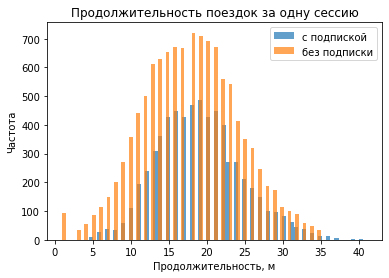

count    11568.000000
mean        17.890992
std          6.330250
min          1.000000
25%         13.000000
50%         18.000000
75%         22.000000
max         35.000000
Name: duration, dtype: float64

In [25]:
plt.hist(df_subscribed['duration'], bins = 70, alpha=0.7, label='с подпиской')
plt.hist(df_no_subscribed['duration'], bins = 70, alpha=0.7, label='без подписки')
plt.title('Продолжительность поездок за одну сессию')
plt.xlabel('Продолжительность, м')
plt.ylabel('Частота')
plt.legend()
plt.show()

df_subscribed['duration'].describe()
df_no_subscribed['duration'].describe()

Теперь сравним продолжительность поездок для пользователей с подпиской и без.

Пользователи с подпиской в среднем тратят 18 минут. Большинство значений лежат от 15 до 22 минут.
Пользователи без подписки в среднем тратят 17 минут. Большинство значений лежат от 13 до 22 минут.
Пользователи без подписки ездят немного меньше.

**Промежуточный вывод**
Среднее расстояние у пользователей с подпиской 3115м. Большинство значений лежат от 2785м до 3559м.
Среднее расстояние у пользователей без подписки 3045м. Большинство значений лежат от 2366м до 3903м.
Разница незначительная, но с подпиской проезжают чуть больше.

Та же ситуация и со временем. Пользователи с подпиской в среднем тратят 18 минут, а без подписки 17 минут.

### шаг. Подсчёт выручки

Создадим датафрейм с агрегированными данными о поездках на основе датафрейма с объединёнными данными из шага 4: найдём суммарное расстояние, количество поездок и суммарное время для каждого пользователя за каждый месяц.

In [26]:
data_pivot = data.pivot_table(index=['user_id', 'month'],
                                values=['distance', 'duration'],
                                aggfunc=['sum', 'count'])
data_pivot

sum             count         
                   distance duration distance duration
user_id month                                         
1       1       7027.511294     42.0        2        2
        4        754.159807      7.0        1        1
        8       6723.470560     46.0        2        2
        10      5809.911100     32.0        2        2
        11      7003.499363     56.0        3        3
...                     ...      ...      ...      ...
1534    6       3409.468534     26.0        2        2
        8       7622.453034     48.0        2        2
        9       4928.173852     23.0        1        1
        11     13350.015305     78.0        4        4
        12      2371.711192     16.0        1        1

[11331 rows x 4 columns]

Нужно добавмть столбец с помесячной выручкой. Помесячная выручка считается по формуле: (стоимость старта поездки *  количество поездок) + (стоимость одной минуты поездки * общая продолжительность всех поездок в минутах) + стоимость подписки.

без подписки 
абонентская плата отсутствует;
стоимость одной минуты поездки — 
8 рублей;
стоимость старта (начала поездки) — 
50 рублей;

с подпиской Ultra 
абонентская плата — 
199 рублей в месяц;
стоимость одной минуты поездки — 
6 рублей;
стоимость старта — бесплатно.

In [27]:
data_pivot = data_pivot.reset_index()
data_pivot

user_id month           sum             count         
                         distance duration distance duration
0           1     1   7027.511294     42.0        2        2
1           1     4    754.159807      7.0        1        1
2           1     8   6723.470560     46.0        2        2
3           1    10   5809.911100     32.0        2        2
4           1    11   7003.499363     56.0        3        3
...       ...   ...           ...      ...      ...      ...
11326    1534     6   3409.468534     26.0        2        2
11327    1534     8   7622.453034     48.0        2        2
11328    1534     9   4928.173852     23.0        1        1
11329    1534    11  13350.015305     78.0        4        4
11330    1534    12   2371.711192     16.0        1        1

[11331 rows x 6 columns]

In [28]:
data_pivot.columns = ['user_id', 'month', 'sum_distance', 'sum_duration', 'count_distance', 'count_duration'] 
data_pivot

,user_id,month,sum_distance,sum_duration,count_distance,count_duration
0,1,1,7027.511294,42.0,2,2
1,1,4,754.159807,7.0,1,1
2,1,8,6723.470560,46.0,2,2
3,1,10,5809.911100,32.0,2,2
4,1,11,7003.499363,56.0,3,3
...,...,...,...,...,...,...
11326,1534,6,3409.468534,26.0,2,2
11327,1534,8,7622.453034,48.0,2,2
11328,1534,9,4928.173852,23.0,1,1
11329,1534,11,13350.015305,78.0,4,4


In [29]:
data_pivot_2 = data_pivot.merge(users, on='user_id', how = 'left')
data_pivot_2

,user_id,month,sum_distance,sum_duration,count_distance,count_duration,name,age,city,subscription_type
0,1,1,7027.511294,42.0,2,2,Кира,22,Тюмень,ultra
1,1,4,754.159807,7.0,1,1,Кира,22,Тюмень,ultra
2,1,8,6723.470560,46.0,2,2,Кира,22,Тюмень,ultra
3,1,10,5809.911100,32.0,2,2,Кира,22,Тюмень,ultra
4,1,11,7003.499363,56.0,3,3,Кира,22,Тюмень,ultra
...,...,...,...,...,...,...,...,...,...,...
11326,1534,6,3409.468534,26.0,2,2,Альберт,25,Краснодар,free
11327,1534,8,7622.453034,48.0,2,2,Альберт,25,Краснодар,free
11328,1534,9,4928.173852,23.0,1,1,Альберт,25,Краснодар,free
11329,1534,11,13350.015305,78.0,4,4,Альберт,25,Краснодар,free


In [30]:
def monthly_revenue(row):
    subscription_type = row['subscription_type']
    count_distance = row['count_distance']
    sum_duration = row['sum_duration']
    if subscription_type == 'ultra':
        return (6 * sum_duration + 199)
    if subscription_type == 'free':
        return (50 * count_distance) + (8 * sum_duration)

In [31]:
data_pivot_2['monthly_revenue'] = data_pivot_2.apply(monthly_revenue, axis=1)
data_pivot_2

,user_id,month,sum_distance,sum_duration,count_distance,count_duration,name,age,city,subscription_type,monthly_revenue
0,1,1,7027.511294,42.0,2,2,Кира,22,Тюмень,ultra,451.0
1,1,4,754.159807,7.0,1,1,Кира,22,Тюмень,ultra,241.0
2,1,8,6723.470560,46.0,2,2,Кира,22,Тюмень,ultra,475.0
3,1,10,5809.911100,32.0,2,2,Кира,22,Тюмень,ultra,391.0
4,1,11,7003.499363,56.0,3,3,Кира,22,Тюмень,ultra,535.0
...,...,...,...,...,...,...,...,...,...,...,...
11326,1534,6,3409.468534,26.0,2,2,Альберт,25,Краснодар,free,308.0
11327,1534,8,7622.453034,48.0,2,2,Альберт,25,Краснодар,free,484.0
11328,1534,9,4928.173852,23.0,1,1,Альберт,25,Краснодар,free,234.0
11329,1534,11,13350.015305,78.0,4,4,Альберт,25,Краснодар,free,824.0


Таблица обработана, помесячная выручка посчитана, приступим к проверке гипотез.

### шаг. Проверка гипотез

Важно понять, тратят ли пользователи с подпиской больше времени на поездки? Если да, то пользователи с подпиской могут быть «выгоднее» для компании. Проверим гипотезу. 

Нулевая гипотеза: о том, что среднее время поездок пользователей с подпиской и среднее время поездок пользователей без подписки равны.

Альтернативная: о том, что среднее время поездок пользователей с подпиской больше, чем среднее время поездок пользователей без подписки.

In [32]:
alpha = 0.05 

results = st.ttest_ind(df_subscribed['duration'] , df_no_subscribed['duration'], alternative='greater')

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу') 

print()
print('Среднее время поездок пользователей с подпиской', df_subscribed['duration'].mean())
print('Среднее время поездок пользователей без подписки', df_no_subscribed['duration'].mean())

p-значение: 2.4959453720736625e-34
Отвергаем нулевую гипотезу

Среднее время поездок пользователей с подпиской 19.037692307692307
Среднее время поездок пользователей без подписки 17.890992392807746


Так как мы отвергаем нулевую гипотезу, то получается, что среднее время у пользователей с подпиской выше, чем у пользователей без подписки. 

Расстояние одной поездки в 3130 метров — оптимальное с точки зрения износа самоката. Можно ли сказать, что среднее расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает 3130 метров?

Нулевая гипотеза: среднее расстояние, которое проезжают пользователи с подпиской за одну поездку = 3130 метров

Альтернативная гипотеза: пользователи с подпиской за одну сессию проезжают больше 3130 метров

In [33]:
optimal_distance = 3130

alpha = 0.05 

results = st.ttest_1samp(df_subscribed['distance'], optimal_distance, alternative='greater')

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print('Отвергаем нулевую гипотезу')
else:
    print('Не отвергаем нулевую гипотезу') 

p-значение: 0.9195368847849785
Не отвергаем нулевую гипотезу


Нулевая гипотеза не была отвегнута, соответственно можно говорить, что среднее расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает 3130 метров.


Проверим гипотезу о том, будет ли помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки.

Нулевая гипотеза: среднее значение помесячной выручки пользователей с подпиской равно среднему значению помесячной выручки пользователей без подписки.

Альтернативная гипотеза: среднее значение помесячной выручки пользователей с подпиской выше среднего значения помесячной выручки пользователей без подписки.

In [34]:
alpha = 0.05 

results = st.ttest_ind(data_pivot_2.query('subscription_type == "ultra"')['monthly_revenue'] , data_pivot_2.query('subscription_type == "free"')['monthly_revenue'], alternative='greater')

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу') 
    
print()
print('Среднее значение выручки пользователей с подпиской', data_pivot_2.query('subscription_type == "ultra"')['monthly_revenue'].mean())
print('Среднее значение выручки пользователей без подписки', data_pivot_2.query('subscription_type == "free"')['monthly_revenue'].mean())

p-значение: 1.8850394384715216e-31
Отвергаем нулевую гипотезу

Среднее значение выручки пользователей с подпиской 362.7921906022502
Среднее значение выручки пользователей без подписки 328.6413651073845


Отвергаем нулевую гипотезу, соответственно среднее значение помесячной выручки пользователей с подпиской выше среднего значения помесячной выручки пользователей без подписки.

Представьте такую ситуацию: техническая команда сервиса обновила сервера, с которыми взаимодействует мобильное приложение. Она надеется, что из-за этого количество обращений в техподдержку значимо снизилось. Некоторый файл содержит для каждого пользователя данные о количестве обращений до обновления и после него. Какой тест вам понадобился бы для проверки этой гипотезы?

Так как у нас зависимые выборки (мы анализируем одну генеральную совокупность, с которой произошли некоторые изменения), то будем использовать гипотезу о равенстве средних для зависимых (парных) выборок.

Применим метод scipy.stats.ttest_rel()

**Промежуточный вывод**

Согласно проверке наших гипотез мы получили следующие заключения:
* среднее время у пользователей с подпиской выше, чем у пользователей без подписки.
* среднее расстояние = 3130 метров.
* среднее значение помесячной выручки пользователей с подпиской выше среднего значения помесячной выручки пользователей без подписки.

### шаг. Общий вывод

В работе над данным проектом я загрузила и изучила датафреймы, провела предобработку данных в ходе которой удалила явные дубликаты и проверила на пропуски. Также был создан столбец с номером месяца для дальнейшей работы. 
В исследовательской части проекта была описана и визуализирована общая информация о пользователях и поездках. Получила следующие данные: большинство поездок длились от 14 до 22 минут, в основном пользователи проезжают от 2500 до 3500 м. Самый популярный город -- Пятигорск и большинство пользователей пользуются сервисом без подписки. Средний возраст 25 лет, минимальный - 12. Очень мало пользователей старше 40 лет.

Затем я решила сосредоточиться на анализе пользователей с подпиской и без. Для этого создала один датафрейм из users и rides, а затем создала два датафрейма, в один поместила пользователей с подпиской, в другой без. Визуализировала информацию о расстоянии и времени поездок для пользователей обеих категорий. Пришла к следующим заключениям:

Среднее расстояние у пользователей с подпиской 3115м. Большинство значений лежат от 2785м до 3559м. Среднее расстояние у пользователей без подписки 3045м. Большинство значений лежат от 2366м до 3903м. Разница небольшая, но с подпиской проезжают чуть больше.

Пользователи с подпиской в среднем тратят 18 минут. Большинство значений лежат от 15 до 22 минут. Пользователи без подписки в среднем тратят 17 минут. Большинство значений лежат от 13 до 22 минут. Пользователи без подписки ездят немного меньше.


Следующим шагом я создала датафрейм с агрегированными данными о поездках: суммарное расстояние, количество поездок и суммарное время для каждого пользователя за каждый месяц.
В этот же датафрейм добавила столбец с помесячной выручкой, которую принёс каждый пользователь. Эти данные использовались при проверке гипотез. 

В своей работе я проверила три гипотезы:
* Тратят ли пользователи с подпиской больше времени на поездки?

среднее время у пользователей с подпиской выше, чем у пользователей без подписки.


* Среднее расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает 3130 метров?

среднее расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает 3130 метров.

* Будет ли помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки.

среднее значение помесячной выручки пользователей с подпиской выше среднего значения помесячной выручки пользователей без подписки.

Итого, можно утверждать, что пользователи с подпиской приносят компании бОльшую прибыль, но разрыв невелик. Разница в среднем значении выручки составляет 36,7 рублей. В среднем проезжают пользователи с подпиской на минуту дольше и на 70м дальше.

**Рекомендации:** проанализировать распределение и опыт использования самокатов в Пятигорске, чтобы понять почему он самый популярный и получить рекомендации для использования в других городах. Например, проанализировать плотность размещения самокатов по городу. Ещё интересно собирать данные по зарядке, так как пользователь принимает решение пользоваться ли самокатом исходя из уровня заряда. 